In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))
from scripts.plant_config import plant_config
from pvlib import location, solarposition, irradiance
from scripts.clear_sky_model import calculate_clear_sky_irradiance
from scripts.system_efficiency import calibrate_system_efficiency
from scripts.partial_shadding_detection import partial_shading_detection
from scripts.point_forecast_prediction import prepare_training_data, train_regression_tree, forecast_point_generation
from scripts.probabilistic_forecast import run_probabilistic_forecast_pipeline
from pathlib import Path
%matplotlib widget

In [2]:
data_path = Path("../data")
merged_data = "merged_data.csv"
config = plant_config

In [3]:
# Read merged data
df = pd.read_csv(data_path / merged_data)

In [4]:
df.head()

,time,pv_output_kw,irradiance_direct,irradiance_diffuse,temperature_pv,hour,month,season,temperature_wx,humidity,wind_speed,wind_direction,mean_sea_level_pressure,cloudiness
0,2019-01-01 00:00:00+00:00,0.0,0.0,0.0,0.912,0,1,Winter,0.68,98.90,1.38,268.3,95.88,0.5029
1,2019-01-01 01:00:00+00:00,0.0,0.0,0.0,0.864,1,1,Winter,0.64,98.94,1.36,262.4,95.87,0.6432
2,2019-01-01 02:00:00+00:00,0.0,0.0,0.0,0.833,2,1,Winter,0.64,98.91,1.42,254.5,95.84,1.0000
3,2019-01-01 03:00:00+00:00,0.0,0.0,0.0,0.793,3,1,Winter,0.64,98.84,1.45,249.4,95.78,1.0000
4,2019-01-01 04:00:00+00:00,0.0,0.0,0.0,0.630,4,1,Winter,0.50,98.56,1.47,246.4,95.70,1.0000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   time                     8760 non-null   object 
 1   pv_output_kw             8760 non-null   float64
 2   irradiance_direct        8760 non-null   float64
 3   irradiance_diffuse       8760 non-null   float64
 4   temperature_pv           8760 non-null   float64
 5   hour                     8760 non-null   int64  
 6   month                    8760 non-null   int64  
 7   season                   8760 non-null   object 
 8   temperature_wx           8760 non-null   float64
 9   humidity                 8760 non-null   float64
 10  wind_speed               8760 non-null   float64
 11  wind_direction           8760 non-null   float64
 12  mean_sea_level_pressure  8760 non-null   float64
 13  cloudiness               8760 non-null   float64
dtypes: float64(10), int64(2)

In [6]:
# Rename column time to timestamp
df.rename(columns={"time": "timestamp"}, inplace=True)
# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [7]:
# Calculate clear sky irradiance
df = calculate_clear_sky_irradiance(df, config)

In [8]:
df.head()

,timestamp,pv_output_kw,irradiance_direct,irradiance_diffuse,temperature_pv,hour,month,season,temperature_wx,humidity,...,wind_direction,mean_sea_level_pressure,cloudiness,zenith,azimuth_sun,GHI,DNI,DHI,POA_irradiance,Pcs_kW
0,2019-01-01 00:00:00+00:00,0.0,0.0,0.0,0.912,0,1,Winter,0.68,98.90,...,268.3,95.88,0.5029,153.467842,22.640819,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00+00:00,0.0,0.0,0.0,0.864,1,1,Winter,0.64,98.94,...,262.4,95.87,0.6432,147.611733,48.311134,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 02:00:00+00:00,0.0,0.0,0.0,0.833,2,1,Winter,0.64,98.91,...,254.5,95.84,1.0000,139.159465,66.745701,0.0,0.0,0.0,0.0,0.0
3,2019-01-01 03:00:00+00:00,0.0,0.0,0.0,0.793,3,1,Winter,0.64,98.84,...,249.4,95.78,1.0000,129.564773,80.686691,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 04:00:00+00:00,0.0,0.0,0.0,0.630,4,1,Winter,0.50,98.56,...,246.4,95.70,1.0000,119.592585,92.303776,0.0,0.0,0.0,0.0,0.0


In [9]:
df.columns

Index(['timestamp', 'pv_output_kw', 'irradiance_direct', 'irradiance_diffuse',
       'temperature_pv', 'hour', 'month', 'season', 'temperature_wx',
       'humidity', 'wind_speed', 'wind_direction', 'mean_sea_level_pressure',
       'cloudiness', 'zenith', 'azimuth_sun', 'GHI', 'DNI', 'DHI',
       'POA_irradiance', 'Pcs_kW'],
      dtype='object')

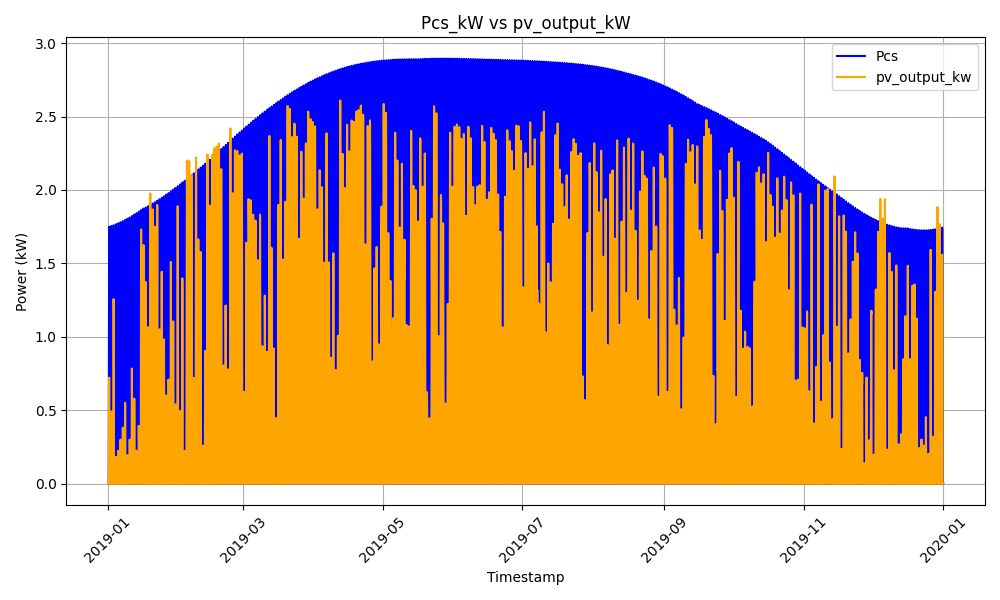

In [10]:
# Plot Pcs vs pv_output_kw
plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], df["Pcs_kW"], label="Pcs", color="blue")
plt.plot(df["timestamp"], df["pv_output_kw"], label="pv_output_kw", color="orange")
plt.xlabel("Timestamp")
plt.ylabel("Power (kW)")
plt.title("Pcs_kW vs pv_output_kW")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig(data_path / "Pcs_vs_pv_output_kw.png")
plt.show()

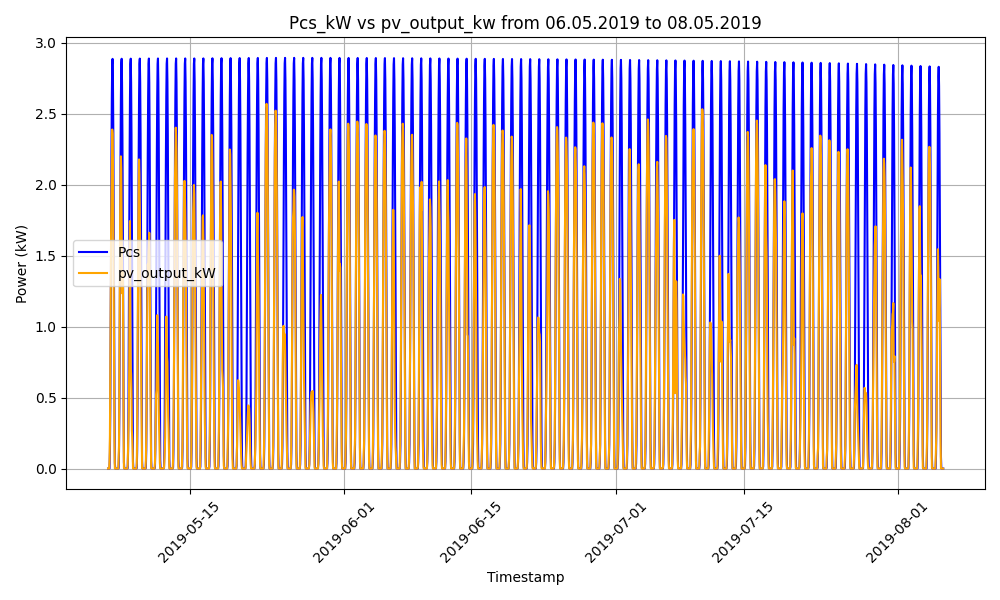

In [11]:
# Plot Pcs vs pv_output_kw from 06.05.2019 to 08.05.2019
plt.figure(figsize=(10, 6))
start_date = "2019-05-06"
end_date = "2019-08-06"
mask = (df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)
plt.plot(df["timestamp"][mask], df["Pcs_kW"][mask], label="Pcs", color="blue")
plt.plot(df["timestamp"][mask], df["pv_output_kw"][mask], label="pv_output_kW", color="orange")
plt.xlabel("Timestamp")
plt.ylabel("Power (kW)")
plt.title("Pcs_kW vs pv_output_kw from 06.05.2019 to 08.05.2019")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig(data_path / "Pcs_vs_pv_output_kw_06_08_05_2019.png")
plt.show()

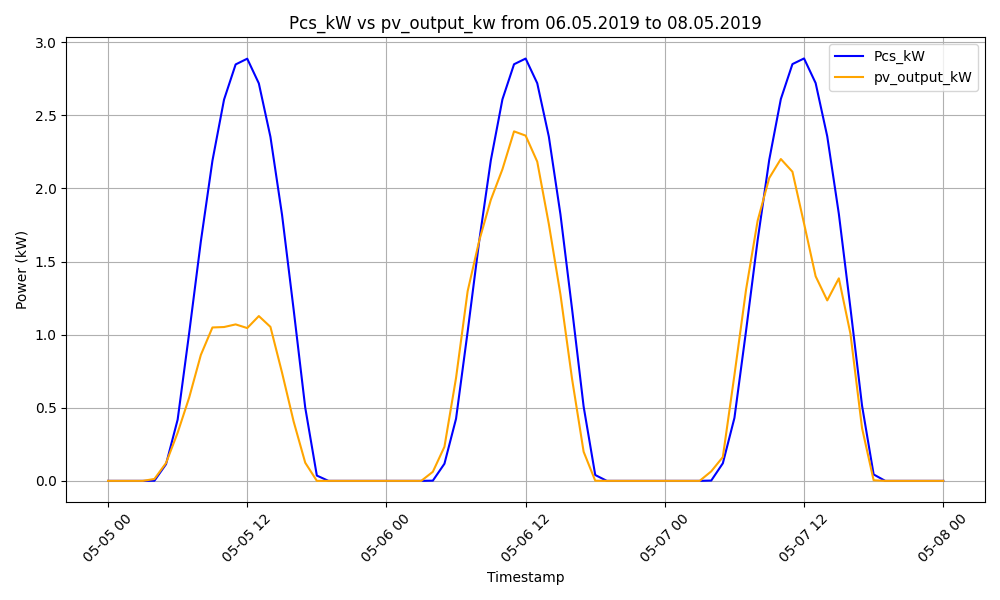

In [12]:
# Plot Pcs vs pv_output_kw from 06.05.2019 to 08.05.2019
plt.figure(figsize=(10, 6))
start_date = "2019-05-05"
end_date = "2019-05-08"
mask = (df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)
plt.plot(df["timestamp"][mask], df["Pcs_kW"][mask], label="Pcs_kW", color="blue")
plt.plot(df["timestamp"][mask], df["pv_output_kw"][mask], label="pv_output_kW", color="orange")
plt.xlabel("Timestamp")
plt.ylabel("Power (kW)")
plt.title("Pcs_kW vs pv_output_kw from 06.05.2019 to 08.05.2019")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig(data_path / "Pcs_vs_pv_output_kw_06_08_05_2019.png")
plt.show()

## System Efficiency Calibration

In [13]:
df.columns

Index(['timestamp', 'pv_output_kw', 'irradiance_direct', 'irradiance_diffuse',
       'temperature_pv', 'hour', 'month', 'season', 'temperature_wx',
       'humidity', 'wind_speed', 'wind_direction', 'mean_sea_level_pressure',
       'cloudiness', 'zenith', 'azimuth_sun', 'GHI', 'DNI', 'DHI',
       'POA_irradiance', 'Pcs_kW'],
      dtype='object')

In [14]:
df, (kc, kt) = calibrate_system_efficiency(
    df,
    pm_col="pv_output_kw",
    pcs_col="Pcs_kW",
    cloud_col="cloudiness",
    temp_col="temperature_wx")

[INFO] Calibrated κc = 0.6910 (cool window)


/Users/dquispe/Documents/repositories/solar_forecasting/scripts/system_efficiency.py:112: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((kc * pcs - pm) / pm)) * 100
/Users/dquispe/Documents/repositories/solar_forecasting/scripts/system_efficiency.py:112: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((kc * pcs - pm) / pm)) * 100


In [15]:
print(f"Final κc: {kc:.4f}, κt: {kt:.4f}")

Final κc: 0.6910, κt: 1.0000


In [16]:
df.head()

,timestamp,pv_output_kw,irradiance_direct,irradiance_diffuse,temperature_pv,hour,month,season,temperature_wx,humidity,...,mean_sea_level_pressure,cloudiness,zenith,azimuth_sun,GHI,DNI,DHI,POA_irradiance,Pcs_kW,Pccs_kW
0,2019-01-01 00:00:00+00:00,0.0,0.0,0.0,0.912,0,1,Winter,0.68,98.90,...,95.88,0.5029,153.467842,22.640819,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00+00:00,0.0,0.0,0.0,0.864,1,1,Winter,0.64,98.94,...,95.87,0.6432,147.611733,48.311134,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 02:00:00+00:00,0.0,0.0,0.0,0.833,2,1,Winter,0.64,98.91,...,95.84,1.0000,139.159465,66.745701,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01 03:00:00+00:00,0.0,0.0,0.0,0.793,3,1,Winter,0.64,98.84,...,95.78,1.0000,129.564773,80.686691,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 04:00:00+00:00,0.0,0.0,0.0,0.630,4,1,Winter,0.50,98.56,...,95.70,1.0000,119.592585,92.303776,0.0,0.0,0.0,0.0,0.0,0.0


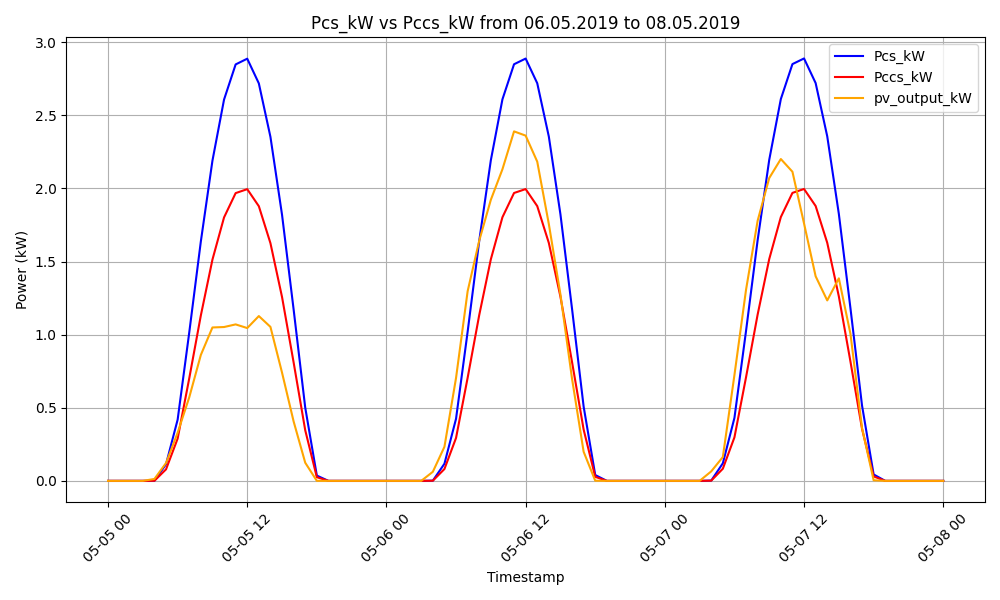

In [17]:
# Plot Pcs vs pv_output_kw from 06.05.2019 to 08.05.2019
plt.figure(figsize=(10, 6))
start_date = "2019-05-05"
end_date = "2019-05-08"
mask = (df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)
plt.plot(df["timestamp"][mask], df["Pcs_kW"][mask], label="Pcs_kW", color="blue")
plt.plot(df["timestamp"][mask], df["Pccs_kW"][mask], label="Pccs_kW", color="red")
plt.plot(df["timestamp"][mask], df["pv_output_kw"][mask], label="pv_output_kW", color="orange")
plt.xlabel("Timestamp")
plt.ylabel("Power (kW)")
plt.title("Pcs_kW vs Pccs_kW from 06.05.2019 to 08.05.2019")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig(data_path / "Pcs_vs_pv_output_kw_06_08_05_2019.png")
plt.show()

In [18]:
df.columns

Index(['timestamp', 'pv_output_kw', 'irradiance_direct', 'irradiance_diffuse',
       'temperature_pv', 'hour', 'month', 'season', 'temperature_wx',
       'humidity', 'wind_speed', 'wind_direction', 'mean_sea_level_pressure',
       'cloudiness', 'zenith', 'azimuth_sun', 'GHI', 'DNI', 'DHI',
       'POA_irradiance', 'Pcs_kW', 'Pccs_kW'],
      dtype='object')

In [19]:
df = partial_shading_detection(df, zenith_col="zenith", power_col="pv_output_kw", pccs_col="Pccs_kW", output_col="Ppccs_kW",)

In [20]:
df.head()

,timestamp,pv_output_kw,irradiance_direct,irradiance_diffuse,temperature_pv,hour,month,season,temperature_wx,humidity,...,cloudiness,zenith,azimuth_sun,GHI,DNI,DHI,POA_irradiance,Pcs_kW,Pccs_kW,Ppccs_kW
0,2019-01-01 00:00:00+00:00,0.0,0.0,0.0,0.912,0,1,Winter,0.68,98.90,...,0.5029,153.467842,22.640819,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00+00:00,0.0,0.0,0.0,0.864,1,1,Winter,0.64,98.94,...,0.6432,147.611733,48.311134,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 02:00:00+00:00,0.0,0.0,0.0,0.833,2,1,Winter,0.64,98.91,...,1.0000,139.159465,66.745701,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01 03:00:00+00:00,0.0,0.0,0.0,0.793,3,1,Winter,0.64,98.84,...,1.0000,129.564773,80.686691,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 04:00:00+00:00,0.0,0.0,0.0,0.630,4,1,Winter,0.50,98.56,...,1.0000,119.592585,92.303776,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df.columns

Index(['timestamp', 'pv_output_kw', 'irradiance_direct', 'irradiance_diffuse',
       'temperature_pv', 'hour', 'month', 'season', 'temperature_wx',
       'humidity', 'wind_speed', 'wind_direction', 'mean_sea_level_pressure',
       'cloudiness', 'zenith', 'azimuth_sun', 'GHI', 'DNI', 'DHI',
       'POA_irradiance', 'Pcs_kW', 'Pccs_kW', 'Ppccs_kW'],
      dtype='object')

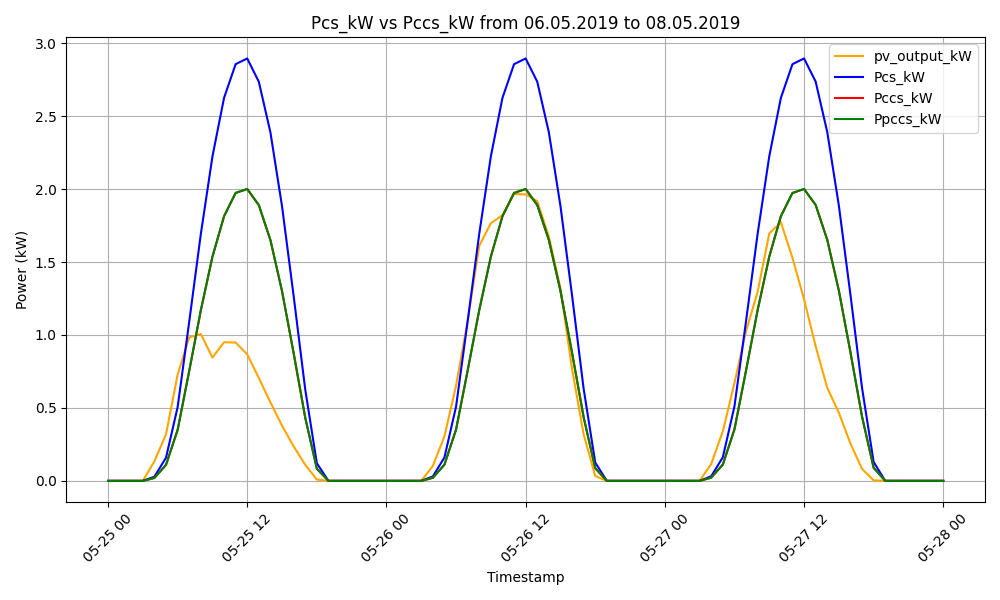

In [22]:
# Plot Pcs vs pv_output_kw from 06.05.2019 to 08.05.2019
plt.figure(figsize=(10, 6))
start_date = "2019-05-25"
end_date = "2019-05-28"
mask = (df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)
plt.plot(df["timestamp"][mask], df["pv_output_kw"][mask], label="pv_output_kW", color="orange")
plt.plot(df["timestamp"][mask], df["Pcs_kW"][mask], label="Pcs_kW", color="blue")
plt.plot(df["timestamp"][mask], df["Pccs_kW"][mask], label="Pccs_kW", color="red")
plt.plot(df["timestamp"][mask], df["Ppccs_kW"][mask], label="Ppccs_kW", color="green")
plt.xlabel("Timestamp")
plt.ylabel("Power (kW)")
plt.title("Pcs_kW vs Pccs_kW from 06.05.2019 to 08.05.2019")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig(data_path / "Pcs_vs_pv_output_kw_06_08_05_2019.png")
plt.show()

## Point Forecast Prediction

In [23]:
df.columns

Index(['timestamp', 'pv_output_kw', 'irradiance_direct', 'irradiance_diffuse',
       'temperature_pv', 'hour', 'month', 'season', 'temperature_wx',
       'humidity', 'wind_speed', 'wind_direction', 'mean_sea_level_pressure',
       'cloudiness', 'zenith', 'azimuth_sun', 'GHI', 'DNI', 'DHI',
       'POA_irradiance', 'Pcs_kW', 'Pccs_kW', 'Ppccs_kW'],
      dtype='object')

In [24]:
# Prepare training data
features = ["temperature_wx", "cloudiness", "humidity"]
X_train, y_train = prepare_training_data(df, features, target_col="pv_output_kw", reference_col="Ppccs_kW")

In [25]:
X_train.head()

,temperature_wx,cloudiness,humidity
8,0.85,0.9910,96.40
9,1.36,0.9830,96.28
10,1.83,0.9418,95.84
11,2.27,0.9748,95.14
12,2.55,0.9864,94.68


In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4449 entries, 8 to 8751
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temperature_wx  4449 non-null   float64
 1   cloudiness      4449 non-null   float64
 2   humidity        4449 non-null   float64
dtypes: float64(3)
memory usage: 139.0 KB


In [27]:
y_train.head()

8     0.360731
9     0.469287
10    0.524191
11    0.502814
12    0.402843
Name: Lambda, dtype: float64

In [28]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 4449 entries, 8 to 8751
Series name: Lambda
Non-Null Count  Dtype  
--------------  -----  
4449 non-null   float64
dtypes: float64(1)
memory usage: 69.5 KB


In [29]:
# Train regression tree
model = train_regression_tree(X_train, y_train)

In [30]:
df.columns

Index(['timestamp', 'pv_output_kw', 'irradiance_direct', 'irradiance_diffuse',
       'temperature_pv', 'hour', 'month', 'season', 'temperature_wx',
       'humidity', 'wind_speed', 'wind_direction', 'mean_sea_level_pressure',
       'cloudiness', 'zenith', 'azimuth_sun', 'GHI', 'DNI', 'DHI',
       'POA_irradiance', 'Pcs_kW', 'Pccs_kW', 'Ppccs_kW'],
      dtype='object')

In [31]:
# Generate point forecast for the next 24 hours
df_forecast = forecast_point_generation(model, df, features, reference_col="Ppccs_kW", output_col="Ppf_kW")

In [32]:
df_forecast.head()

,timestamp,pv_output_kw,irradiance_direct,irradiance_diffuse,temperature_pv,hour,month,season,temperature_wx,humidity,...,zenith,azimuth_sun,GHI,DNI,DHI,POA_irradiance,Pcs_kW,Pccs_kW,Ppccs_kW,Ppf_kW
0,2019-01-01 00:00:00+00:00,0.0,0.0,0.0,0.912,0,1,Winter,0.68,98.90,...,153.467842,22.640819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00+00:00,0.0,0.0,0.0,0.864,1,1,Winter,0.64,98.94,...,147.611733,48.311134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 02:00:00+00:00,0.0,0.0,0.0,0.833,2,1,Winter,0.64,98.91,...,139.159465,66.745701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01 03:00:00+00:00,0.0,0.0,0.0,0.793,3,1,Winter,0.64,98.84,...,129.564773,80.686691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 04:00:00+00:00,0.0,0.0,0.0,0.630,4,1,Winter,0.50,98.56,...,119.592585,92.303776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


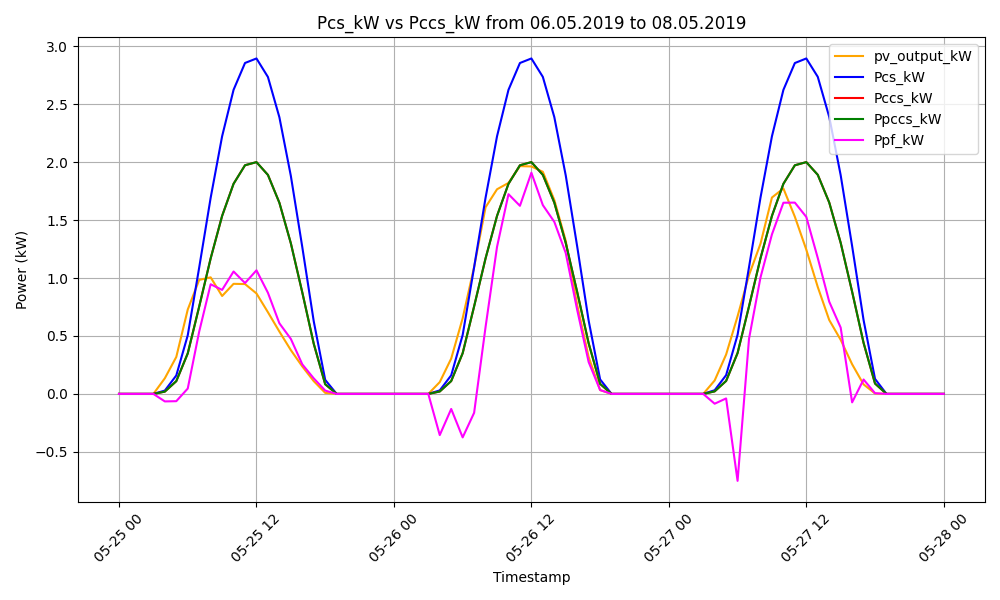

In [33]:
# Plot Pcs vs pv_output_kw from 06.05.2019 to 08.05.2019
plt.figure(figsize=(10, 6))
start_date = "2019-05-25"
end_date = "2019-05-28"
mask = (df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)
plt.plot(df["timestamp"][mask], df_forecast["pv_output_kw"][mask], label="pv_output_kW", color="orange")
plt.plot(df["timestamp"][mask], df_forecast["Pcs_kW"][mask], label="Pcs_kW", color="blue")
plt.plot(df["timestamp"][mask], df_forecast["Pccs_kW"][mask], label="Pccs_kW", color="red")
plt.plot(df["timestamp"][mask], df_forecast["Ppccs_kW"][mask], label="Ppccs_kW", color="green")
plt.plot(df["timestamp"][mask], df_forecast["Ppf_kW"][mask], label="Ppf_kW", color="magenta")
plt.xlabel("Timestamp")
plt.ylabel("Power (kW)")
plt.title("Pcs_kW vs Pccs_kW from 06.05.2019 to 08.05.2019")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig(data_path / "Pcs_vs_pv_output_kw_06_08_05_2019.png")
plt.show()

## Probabilistic Forecast

In [35]:
df_forecast.columns

Index(['timestamp', 'pv_output_kw', 'irradiance_direct', 'irradiance_diffuse',
       'temperature_pv', 'hour', 'month', 'season', 'temperature_wx',
       'humidity', 'wind_speed', 'wind_direction', 'mean_sea_level_pressure',
       'cloudiness', 'zenith', 'azimuth_sun', 'GHI', 'DNI', 'DHI',
       'POA_irradiance', 'Pcs_kW', 'Pccs_kW', 'Ppccs_kW', 'Ppf_kW'],
      dtype='object')

In [37]:
#  Run the probabilistic forecast pipeline
df_result = run_probabilistic_forecast_pipeline(
    df_forecast,
    forecast_col="Ppf_kW",
    actual_col="pv_output_kw",
    cloud_col="cloudiness",
    timestamp_col="timestamp")

/Users/dquispe/Documents/repositories/solar_forecasting/scripts/probabilistic_forecast.py:35: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_1min = df.resample("1min").interpolate(method="linear")
/Users/dquispe/Documents/repositories/solar_forecasting/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


In [38]:
df_result.head()

,pv_output_kw,irradiance_direct,irradiance_diffuse,temperature_pv,hour,month,season,temperature_wx,humidity,wind_speed,...,lambda_class,Ppp_10,Ppp_20,Ppp_30,Ppp_40,Ppp_50,Ppp_60,Ppp_70,Ppp_80,Ppp_90
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,0.0,0.0,0.0,0.9120,0.000000,1.0,Winter,0.680000,98.900000,1.380000,...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2019-01-01 00:01:00+00:00,0.0,0.0,0.0,0.9112,0.016667,1.0,NaN,0.679333,98.900667,1.379667,...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2019-01-01 00:02:00+00:00,0.0,0.0,0.0,0.9104,0.033333,1.0,NaN,0.678667,98.901333,1.379333,...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2019-01-01 00:03:00+00:00,0.0,0.0,0.0,0.9096,0.050000,1.0,NaN,0.678000,98.902000,1.379000,...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2019-01-01 00:04:00+00:00,0.0,0.0,0.0,0.9088,0.066667,1.0,NaN,0.677333,98.902667,1.378667,...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
